# NSynth - Classify Velocity Features
Code References:
- Data loading: https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3
- Logistic Regression: https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
sns.set(font_scale = 1.7)
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import time
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
# from https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [3]:
## From. https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html
class LogisticRegression(nn.Module):  

    def __init__(self, input_size, num_labels):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_labels)
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)

In [4]:
def train_spec(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    loss_output = list()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = train_loss/(batch_idx+1)/len(train_loader.dataset)
    loss_output.append(train_loss)
#     print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
#         epoch, train_loss, 100. * correct / len(train_loader.dataset)))
    acc = 100. * correct / len(train_loader.dataset)
    return(loss_output, acc)

def test_spec(model, test_loader, criterion, epoch, batch_size = 64):
    model.eval()
    test_loss = 0
    correct = 0
    loss_output = list()
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    loss_output.append(test_loss)
#     print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
#         epoch, test_loss, 100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    return(loss_output, acc)

In [5]:
def run_logistic_regression(in_channels, out_channels, dtrain, 
                            dtest, feature, seed, lr, num_epochs,
                           momentum):
    device = 'cuda'
    torch.manual_seed(seed)
    device = torch.device(device)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = LogisticRegression(in_channels, out_channels).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 

    train_loss = list()
    test_loss = list()
    train_acc = list()
    test_acc = list()
    print(feature)
    for epoch in range(1, num_epochs + 1):
        tl, ta = train_spec(model, dtrain, criterion, optimizer, epoch)
        train_loss.append(tl)
        train_acc.append(ta)
        testl, testa = test_spec(model, dtest, criterion, epoch)
        test_loss.append(testl)
        test_acc.append(testa)

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_loss, color = 'C1')
    plt.title('Test Loss')
    plt.show()
    ## Return final train and test accuracy
    return(ta, testa)

In [6]:
def linreg(data_train, data_test, labels_train, labels_test, feature):
    reg = LinearRegression(normalize=False).fit(data_train, labels_train)
    pred_train = reg.predict(data_train)
    pred_test = reg.predict(data_test)
    ## Return RMSE
    rmse_train = np.sqrt(np.mean((labels_train - pred_train)**2))
    rmse_test = np.sqrt(np.mean((labels_test - pred_test)**2))
    print(feature, np.round([rmse_train, rmse_test], 3))
    return(rmse_train, rmse_test)

In [7]:
## Load in data
labels = np.load('../../Data/NSynth/accoustic-labels.npz')
inds = np.load('../../Data/NSynth/accoustic-train-test-inds.npz')

instrument_family = labels['arr_0']
instrument = labels['arr_1']
pitch = labels['arr_2']
velocity = labels['arr_3']
sound_qualities = labels['arr_4']
source = labels['arr_5']

## train_test split
train_inds = inds['arr_0']
test_inds = inds['arr_1']
train_if = instrument_family[train_inds]
test_if = instrument_family[test_inds]

train_pitch = pitch[train_inds]
test_pitch = pitch[test_inds]

train_velocity = velocity[train_inds]
test_velocity = velocity[test_inds]

## transform instrument families
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_trans = le.fit_transform(test_if)
train_trans = le.fit_transform(train_if)

Regular


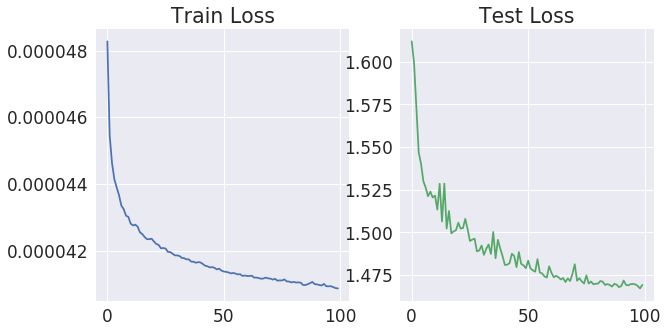

pitch [ 7.048 30.751]
velocity [22.559 86.711]
Regular


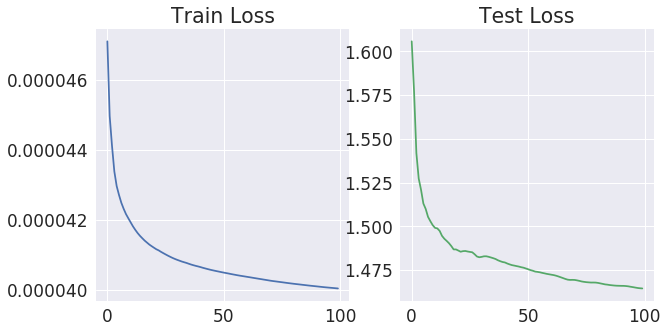

pitch [10.248 11.248]
velocity [31.038 35.157]
Regular


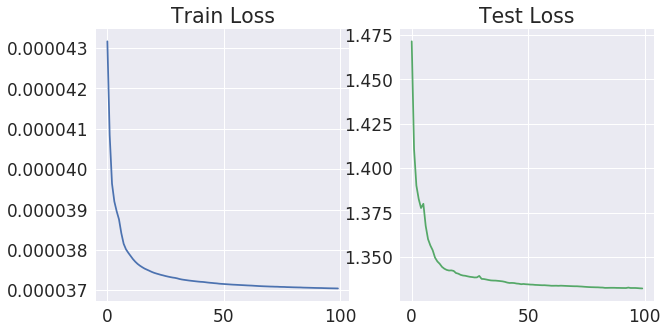

pitch [ 5.978 28.51 ]
velocity [ 25.213 120.743]
Regular


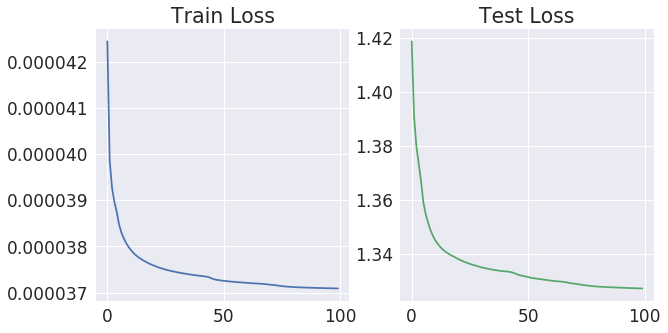

pitch [7.438 7.879]
velocity [29.532 31.958]
Regular


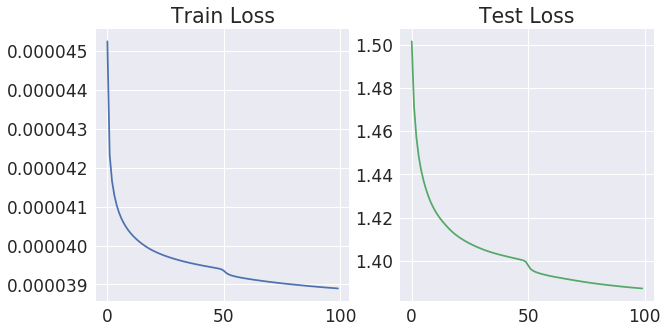

pitch [9.777 9.728]
velocity [31.604 32.302]
Regular


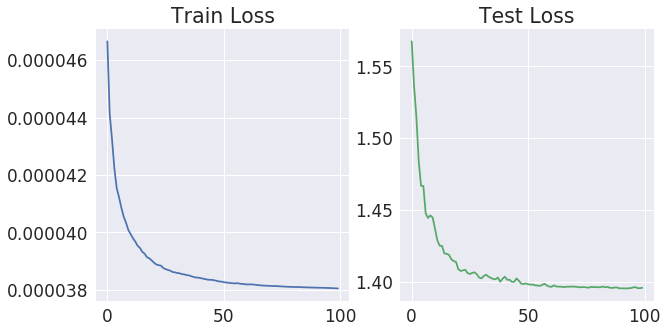

pitch [ 8.135 33.881]
velocity [22.78  98.797]
Regular


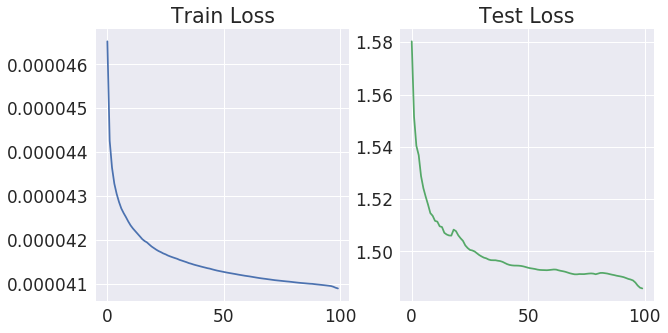

pitch [10.352 11.132]
velocity [30.705 34.801]
Regular


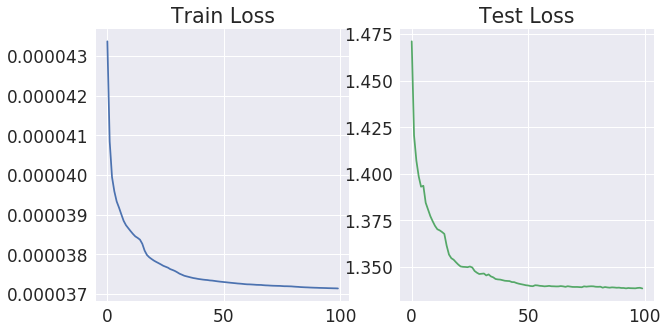

pitch [ 5.893 49.001]
velocity [ 24.965 121.98 ]
Regular


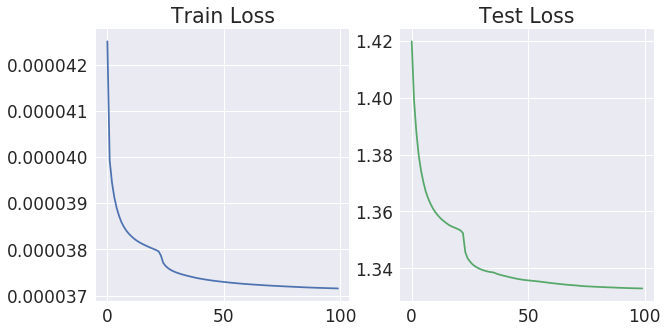

pitch [7.669 8.061]
velocity [29.634 32.317]
Regular


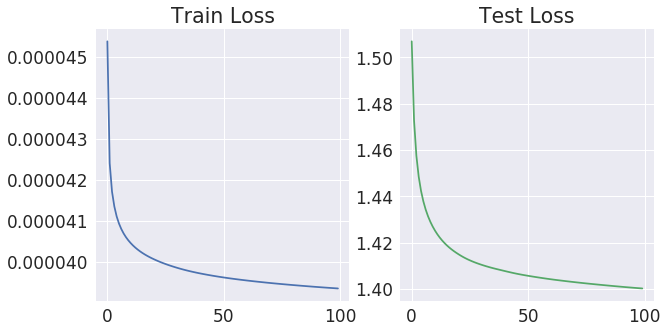

pitch [10.014  9.998]
velocity [31.612 32.477]
Regular


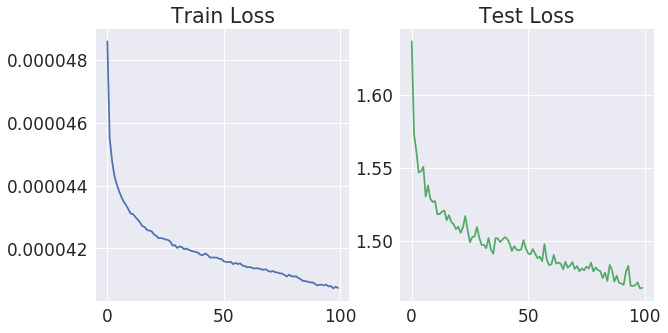

pitch [ 7.319 30.91 ]
velocity [22.701 98.783]
Regular


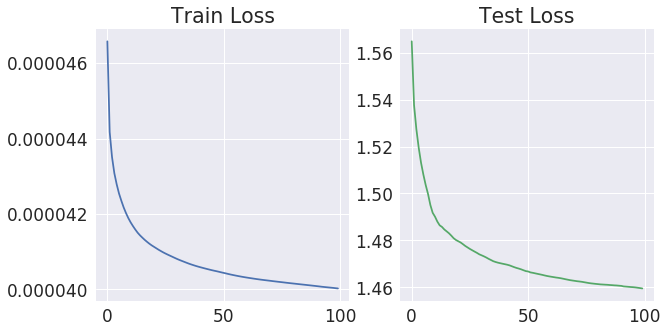

pitch [11.906 13.317]
velocity [31.207 35.65 ]
Regular


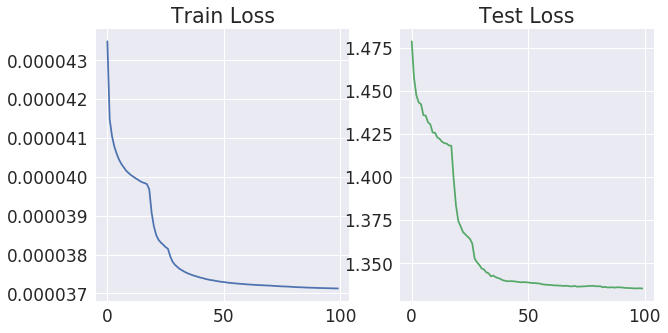

pitch [ 5.928 28.827]
velocity [24.961 75.448]
Regular


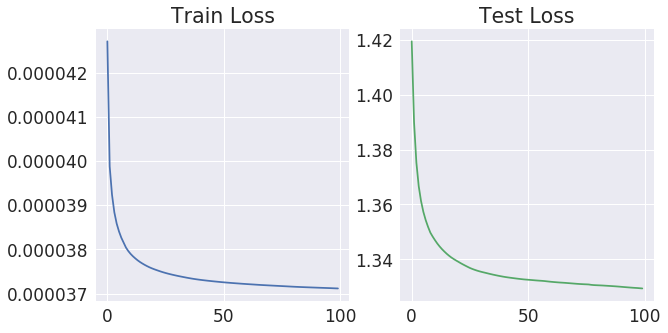

pitch [7.419 7.845]
velocity [29.463 31.908]
Regular


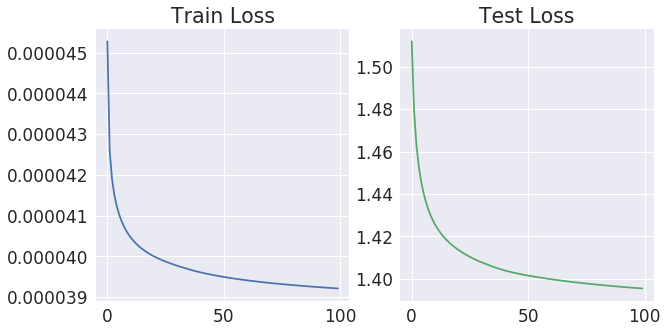

pitch [9.603 9.48 ]
velocity [31.512 32.19 ]
[[[84.514 80.9  ]
  [88.146 81.713]
  [97.846 94.793]
  [97.857 95.407]
  [92.5   89.72 ]]

 [[94.334 88.347]
  [84.786 79.44 ]
  [97.54  94.14 ]
  [97.657 94.76 ]
  [90.8   88.473]]

 [[85.026 81.06 ]
  [88.031 82.007]
  [97.589 94.367]
  [97.8   95.307]
  [91.337 88.86 ]]

 [[ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]]

 [[ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]]]
[[52.775 50.061]
 [52.193 48.632]
 [58.595 56.66 ]
 [58.663 57.095]
 [54.927 53.411]] [[43.232 40.963]
 [42.632 39.718]
 [47.843 46.263]
 [47.898 46.618]
 [44.851 43.611]]
17687.24269604683


In [8]:
start_time = time.time()

out_channels = 8
lr=0.01
momentum=0.9
num_epochs = 100 
arch = 'Regular'
seed = 1
device = 'cuda'
bs = 64
## All five initializations
results_class = np.zeros((5, 5, 2))
results_pitch = np.zeros((5, 5, 2))
results_vel = np.zeros((5, 5, 2))

# for i in range(5):
for i in range(3):
    ## Read in data
    feat = np.load('../../Deep-Features/NSynth-Velocity/'+arch+'-'+str(i)+'-train.npz')
    l1 = feat['arr_0']
    pool1 = feat['arr_1']
    l2 = feat['arr_2']
    pool2 = feat['arr_3']
    l3 = feat['arr_4']
    
    ## Flatten and scale
    l1 = l1.reshape(-1, 124*124)
    scaler = preprocessing.StandardScaler().fit(l1)
    l1_train = scaler.transform(l1)
    pool1 = pool1.reshape(-1, 62*62)
    scaler = preprocessing.StandardScaler().fit(pool1)
    pool1_train = scaler.transform(pool1)
    l2 = l2.reshape(-1, l2.shape[1]*l2.shape[2]*l2.shape[3])
    scaler = preprocessing.StandardScaler().fit(l2)
    l2_train = scaler.transform(l2)
    pool2 = pool2.reshape(-1, pool2.shape[1]*pool2.shape[2]*pool2.shape[3])
    scaler = preprocessing.StandardScaler().fit(pool2)
    pool2_train = scaler.transform(pool2)
    l3 = l3.reshape(-1, l3.shape[1]*l3.shape[2]*l3.shape[3])
    scaler = preprocessing.StandardScaler().fit(l3)
    l3_train = scaler.transform(l3)
    
    ## Test Features
    feat = np.load('../../Deep-Features/NSynth-Velocity/'+arch+'-'+str(i)+'-test.npz')
    l1 = feat['arr_0']
    pool1 = feat['arr_1']
    l2 = feat['arr_2']
    pool2 = feat['arr_3']
    l3 = feat['arr_4']
    
    ## Flatten and scale
    l1 = l1.reshape(-1, 124*124)
    scaler = preprocessing.StandardScaler().fit(l1)
    l1_test = scaler.transform(l1)
    pool1 = pool1.reshape(-1, 62*62)
    scaler = preprocessing.StandardScaler().fit(pool1)
    pool1_test = scaler.transform(pool1)
    l2 = l2.reshape(-1, l2.shape[1]*l2.shape[2]*l2.shape[3])
    scaler = preprocessing.StandardScaler().fit(l2)
    l2_test = scaler.transform(l2)
    pool2 = pool2.reshape(-1, pool2.shape[1]*pool2.shape[2]*pool2.shape[3])
    scaler = preprocessing.StandardScaler().fit(pool2)
    pool2_test = scaler.transform(pool2)
    l3 = l3.reshape(-1, l3.shape[1]*l3.shape[2]*l3.shape[3])
    scaler = preprocessing.StandardScaler().fit(l3)
    l3_test = scaler.transform(l3)
    
    feats_train = [l1_train, pool1_train, l2_train, pool2_train, l3_train]
    feats_test = [l1_test, pool1_test, l2_test, pool2_test, l3_test]
    for j in range(5): ## loop over layers
        train_set = MyDataset(feats_train[j], train_trans)
        dtrain = DataLoader(train_set, batch_size=bs, shuffle=False)
        test_set = MyDataset(feats_test[j], test_trans)
        dtest = DataLoader(test_set, batch_size=bs, shuffle=False)

        in_channels = feats_train[j].shape[1]
        ta, testa = run_logistic_regression(in_channels, out_channels, 
                                            dtrain, dtest, arch, seed, 
                                            lr, num_epochs, momentum)
        results_class[i, j, :] = [ta, testa]
        ## Transfer learning tasks - regressions
        results_pitch[i, j, :] = linreg(feats_train[j], feats_test[j], train_pitch, 
                                        test_pitch, 'pitch')
        results_vel[i, j, :] = linreg(feats_train[j], feats_test[j], train_velocity, 
                                      test_velocity, 'velocity')
    np.savez('Results/Regular-Velocity2', results_class, results_pitch, results_vel)
print(np.round(results_class, 3))
print(np.round(np.mean(results_class, axis = 0), 3), 
      np.round(np.std(results_class, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
np.savez('Results/Regular-Velocity2', results_class, results_pitch, results_vel)

Deformable


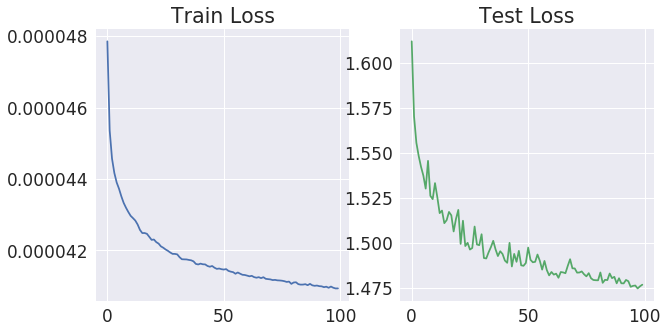

pitch [ 7.303 26.824]
velocity [22.636 88.075]
Deformable


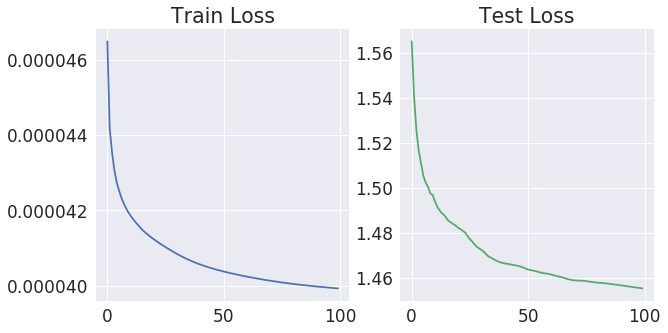

pitch [11.739 12.91 ]
velocity [31.26  35.438]
Deformable


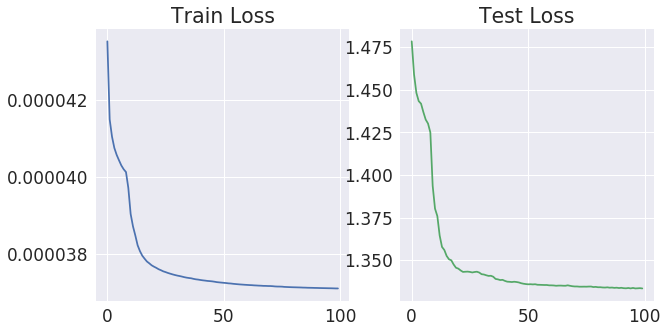

pitch [ 5.823 24.308]
velocity [25.032 70.424]
Deformable


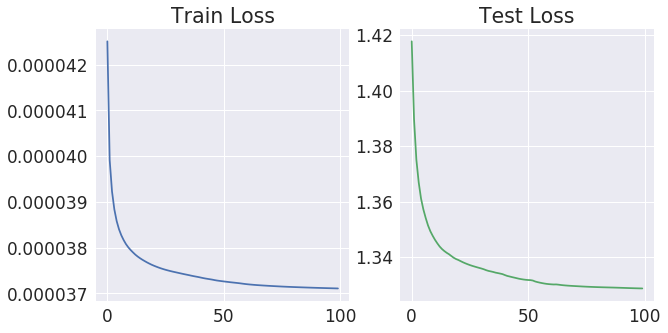

pitch [7.644 8.187]
velocity [29.771 32.22 ]
Deformable


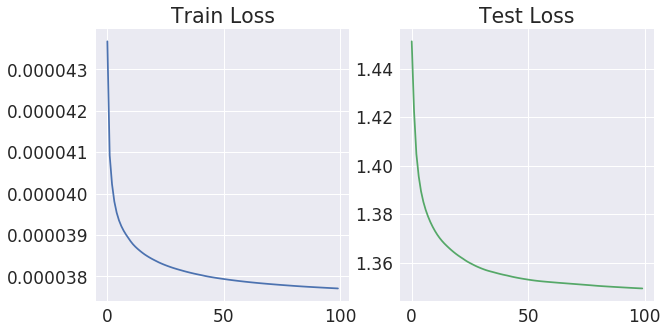

pitch [8.507 8.728]
velocity [30.371 31.695]
Deformable


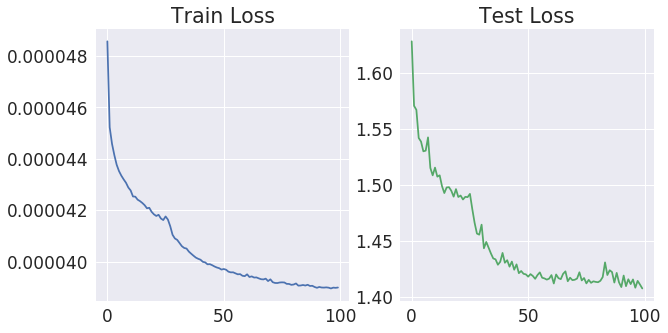

pitch [ 7.139 61.486]
velocity [ 23.015 150.083]
Deformable


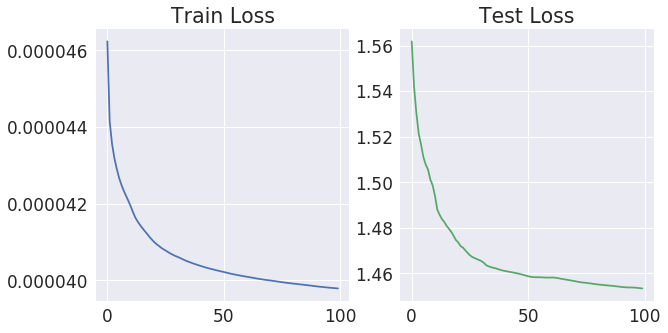

pitch [10.677 11.653]
velocity [30.907 35.084]
Deformable


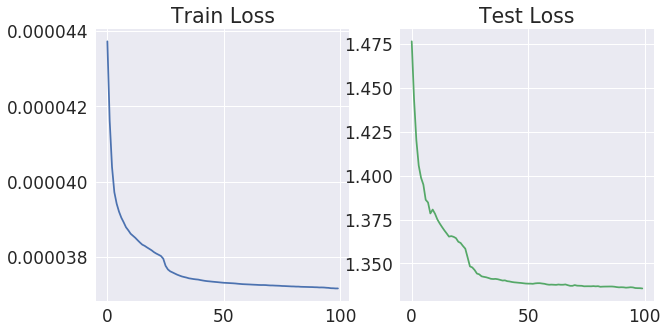

pitch [ 5.891 41.171]
velocity [ 25.069 126.153]
Deformable


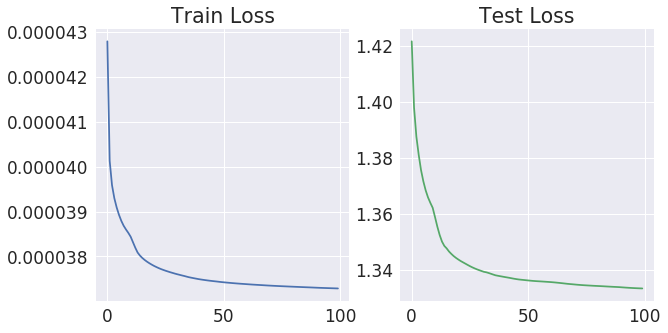

pitch [7.56  7.993]
velocity [29.792 32.288]
Deformable


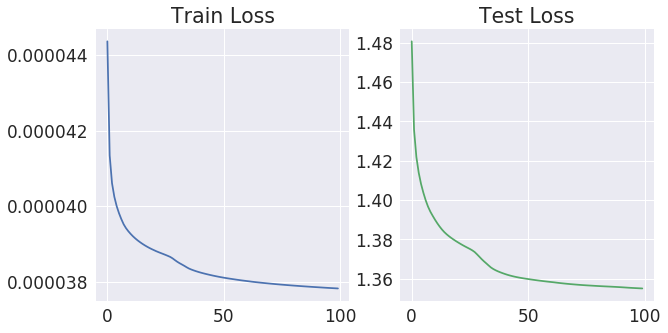

pitch [8.736 8.893]
velocity [30.592 31.848]
[[[ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]]

 [[ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]]

 [[ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]
  [ 0.     0.   ]]

 [[84.257 80.113]
  [88.5   82.673]
  [97.711 94.64 ]
  [97.811 95.26 ]
  [96.189 93.247]]

 [[91.257 87.1  ]
  [88.934 82.813]
  [97.477 94.373]
  [97.203 94.7  ]
  [95.889 92.827]]]
[[35.103 33.443]
 [35.487 33.097]
 [39.038 37.803]
 [39.003 37.992]
 [38.415 37.215]] [[43.049 41.018]
 [43.463 40.536]
 [47.811 46.299]
 [47.769 46.531]
 [47.049 45.579]]
11742.438767910004


In [9]:
start_time = time.time()

out_channels = 8
lr=0.01
momentum=0.9
num_epochs = 100 
arch = 'Deformable'
seed = 1
device = 'cuda'
bs = 64
## All five initializations
results_class = np.zeros((5, 5, 2))
results_pitch = np.zeros((5, 5, 2))
results_vel = np.zeros((5, 5, 2))

for i in range(3,5):
    ## Read in data
    feat = np.load('../../Deep-Features/NSynth-Velocity/'+arch+'-'+str(i)+'-train.npz')
    l1 = feat['arr_0']
    pool1 = feat['arr_1']
    l2 = feat['arr_2']
    pool2 = feat['arr_3']
    l3 = feat['arr_4']
    
    ## Flatten and scale
    l1 = l1.reshape(-1, 124*124)
    scaler = preprocessing.StandardScaler().fit(l1)
    l1_train = scaler.transform(l1)
    pool1 = pool1.reshape(-1, 62*62)
    scaler = preprocessing.StandardScaler().fit(pool1)
    pool1_train = scaler.transform(pool1)
    l2 = l2.reshape(-1, l2.shape[1]*l2.shape[2]*l2.shape[3])
    scaler = preprocessing.StandardScaler().fit(l2)
    l2_train = scaler.transform(l2)
    pool2 = pool2.reshape(-1, pool2.shape[1]*pool2.shape[2]*pool2.shape[3])
    scaler = preprocessing.StandardScaler().fit(pool2)
    pool2_train = scaler.transform(pool2)
    l3 = l3.reshape(-1, l3.shape[1]*l3.shape[2]*l3.shape[3])
    scaler = preprocessing.StandardScaler().fit(l3)
    l3_train = scaler.transform(l3)
    
    ## Test Features
    feat = np.load('../../Deep-Features/NSynth-Velocity/'+arch+'-'+str(i)+'-test.npz')
    l1 = feat['arr_0']
    pool1 = feat['arr_1']
    l2 = feat['arr_2']
    pool2 = feat['arr_3']
    l3 = feat['arr_4']
    
    ## Flatten and scale
    l1 = l1.reshape(-1, 124*124)
    scaler = preprocessing.StandardScaler().fit(l1)
    l1_test = scaler.transform(l1)
    pool1 = pool1.reshape(-1, 62*62)
    scaler = preprocessing.StandardScaler().fit(pool1)
    pool1_test = scaler.transform(pool1)
    l2 = l2.reshape(-1, l2.shape[1]*l2.shape[2]*l2.shape[3])
    scaler = preprocessing.StandardScaler().fit(l2)
    l2_test = scaler.transform(l2)
    pool2 = pool2.reshape(-1, pool2.shape[1]*pool2.shape[2]*pool2.shape[3])
    scaler = preprocessing.StandardScaler().fit(pool2)
    pool2_test = scaler.transform(pool2)
    l3 = l3.reshape(-1, l3.shape[1]*l3.shape[2]*l3.shape[3])
    scaler = preprocessing.StandardScaler().fit(l3)
    l3_test = scaler.transform(l3)
    
    feats_train = [l1_train, pool1_train, l2_train, pool2_train, l3_train]
    feats_test = [l1_test, pool1_test, l2_test, pool2_test, l3_test]
    for j in range(5): ## loop over layers
        train_set = MyDataset(feats_train[j], train_trans)
        dtrain = DataLoader(train_set, batch_size=bs, shuffle=False)
        test_set = MyDataset(feats_test[j], test_trans)
        dtest = DataLoader(test_set, batch_size=bs, shuffle=False)

        in_channels = feats_train[j].shape[1]
        ta, testa = run_logistic_regression(in_channels, out_channels, 
                                            dtrain, dtest, arch, seed, 
                                            lr, num_epochs, momentum)
        results_class[i, j, :] = [ta, testa]
        ## Transfer learning tasks - regressions
        results_pitch[i, j, :] = linreg(feats_train[j], feats_test[j], train_pitch, 
                                        test_pitch, 'pitch')
        results_vel[i, j, :] = linreg(feats_train[j], feats_test[j], train_velocity, 
                                      test_velocity, 'velocity')
    np.savez('Results/Deformable-Velocity2', results_class, results_pitch, results_vel)
print(np.round(results_class, 3))
print(np.round(np.mean(results_class, axis = 0), 3), 
      np.round(np.std(results_class, axis = 0), 3))
end_time = time.time()
print(end_time - start_time)
np.savez('Results/Deformable-Velocity2', results_class, results_pitch, results_vel)

In [17]:
np.savez('Results/Deformable-Velocity', results_class, results_pitch, results_vel)